# Reccurent Neural Network Classifier

In [164]:
# Loading in dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn

In [165]:
# Reading in the data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## **Data Preprocessing**

In [166]:
# Load dependencies
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder

In [167]:
train_encoded = train.copy()
test_encoded = test.copy()

# List of numeric variables
numeric_vars = ['AI_Interaction_Level', 'Age', 'Satisfaction_with_AI_Services',
                'AI_Personalization_Effectiveness', 'Overall_Usage_Frequency',
                'Customer_Service_Interactions', 'Change_in_Usage_Patterns']

# Confirm all numeric variables are of numeric type
train_encoded[numeric_vars] = train_encoded[numeric_vars].apply(pd.to_numeric, errors='coerce')
test_encoded[numeric_vars] = test_encoded[numeric_vars].apply(pd.to_numeric, errors='coerce')

### **Data Standardization**

Standardization models all features to have a mean of 0 and a standard deviation of 1. This method most benefits SVM and Logistic Regression models.

In [168]:
# Initializing the scaler
scaler = StandardScaler()

train_encoded_standardized = train_encoded.copy()
test_encoded_standardized = test_encoded.copy()

# Apply standardization

columns_to_standardize = ['AI_Interaction_Level','Age','Satisfaction_with_AI_Services', 
                        'AI_Personalization_Effectiveness', 'Overall_Usage_Frequency', 
                        'Customer_Service_Interactions', 'Change_in_Usage_Patterns']
train_encoded_standardized[columns_to_standardize] = scaler.fit_transform(train_encoded_standardized[columns_to_standardize])
test_encoded_standardized[columns_to_standardize] = scaler.fit_transform(test_encoded_standardized[columns_to_standardize])

### **Correlation Matrix**

Taken from the initial EDA, we created a correlation matrix as follows:

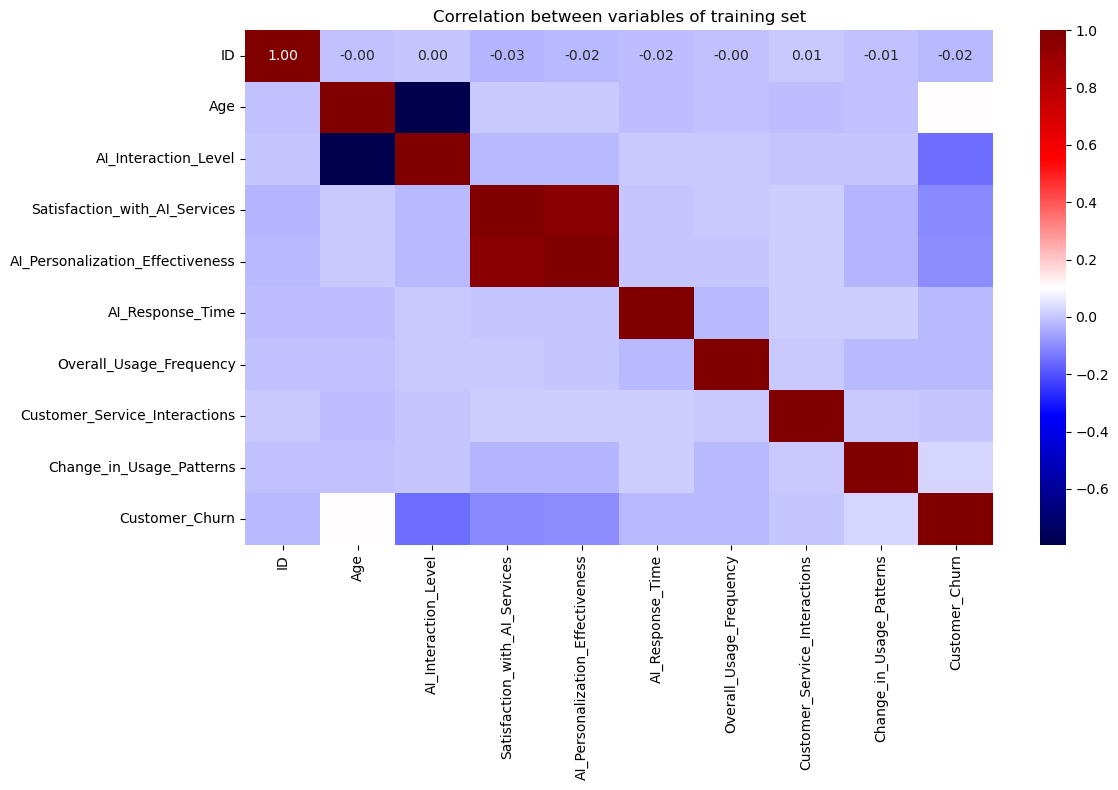

In [169]:
# Plotting correlation matrix
correlation_matrix = train_encoded.corr()

plt.figure(figsize=(12, 8))

# Drawing heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='seismic',
            xticklabels=correlation_matrix.columns,
            yticklabels=correlation_matrix.columns)
plt.title("Correlation between variables of training set")

plt.tight_layout()
plt.show()

## **Feature Engineering**

We combine relevant features into interaction features.

#### 1 | Age & AI Interaction Level

Age and AI interaction level are strongly negatively correlated (-0.79), and display considerable correlation with customer churn (0.11 and -0.15 respectively) Creating this interaction feature aims to uncover non-linear trends that can come about from considering both features heavily.

In [170]:
import pandas as pd

train_encoded_fe = train_encoded.copy()
test_encoded_fe = test_encoded.copy()

train_encoded_fe['Age_AI_Interaction'] = train_encoded['Age'] * train_encoded['AI_Interaction_Level']
test_encoded_fe['Age_AI_Interaction'] = test_encoded['Age'] * test_encoded['AI_Interaction_Level']

#### 2 | Satisfaction with AI Services & AI Personalization Effectiveness

These two features display high colinearrity: 0.96. This may become a problem as considering both features does not bear significant advantages for predicting customer churn compared to simply predicting either one. 

In [171]:
train_encoded_fe['Overall_Satisfaction'] = (train_encoded_fe['Satisfaction_with_AI_Services'] + train_encoded_fe['AI_Personalization_Effectiveness']) / 2
test_encoded_fe['Overall_Satisfaction'] = (test_encoded_fe['Satisfaction_with_AI_Services'] + test_encoded_fe['AI_Personalization_Effectiveness']) / 2

#### 4 | Polynomial Features

In [172]:
# Age squared
train_encoded_fe['Age_Squared'] = train_encoded_fe['Age'] ** 2
test_encoded_fe['Age_Squared'] = test_encoded_fe['Age'] ** 2

# AI-level squared
train_encoded_fe['AI_Level_Squared'] = train_encoded_fe['AI_Interaction_Level'] ** 2
test_encoded_fe['AI_Level_Squared'] = test_encoded_fe['AI_Interaction_Level'] ** 2

In [173]:
train_encoded_fe.head()

,ID,Age,AI_Interaction_Level,Satisfaction_with_AI_Services,AI_Personalization_Effectiveness,AI_Response_Time,Overall_Usage_Frequency,Customer_Service_Interactions,Change_in_Usage_Patterns,Customer_Churn,Age_AI_Interaction,Overall_Satisfaction,Age_Squared,AI_Level_Squared
0,1,59,2,7,7,2,18,5,2,1,118,7.0,3481,4
1,2,49,2,6,5,1,3,2,0,0,98,5.5,2401,4
2,3,35,2,3,3,3,8,2,1,1,70,3.0,1225,4
3,4,63,2,3,3,2,6,6,2,1,126,3.0,3969,4
4,5,28,4,6,6,1,11,3,-1,0,112,6.0,784,16


In [174]:
train_encoded_fe.shape

(5000, 14)

In [175]:
test_encoded_fe.shape

(1250, 14)

In [176]:
#print(train_encoded_fe.isnull().sum())

#### 5 | Binning the Ages

In [177]:
import pandas as pd

In [178]:
# Define bins and their labels
bins = [21, 25, 30, 35, 40, 45, 50, 55, 60, 65]  
labels = ['21-24', '25-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65']

# Bin the age data
train_encoded_fe['Age_Group'] = pd.cut(train_encoded_fe['Age'], bins=bins, labels=labels, right=False)
test_encoded_fe['Age_Group'] = pd.cut(test_encoded_fe['Age'], bins=bins, labels=labels, right=False)

In [179]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
encoder = OneHotEncoder(drop='first')

# Apply encoding to training data
age_groups = train_encoded_fe['Age_Group'].values.reshape(-1, 1)
age_group_encoded = encoder.fit_transform(age_groups).toarray()
column_names = encoder.get_feature_names_out(input_features=['Age_Group'])
age_group_encoded_df = pd.DataFrame(age_group_encoded, columns=column_names, index=train_encoded_fe.index)

# Apply encoding to test data
age_groups_test = test_encoded_fe['Age_Group'].values.reshape(-1, 1)
age_group_encoded_test = encoder.transform(age_groups_test).toarray()
age_group_encoded_test_df = pd.DataFrame(age_group_encoded_test, columns=column_names, index=test_encoded_fe.index)

# Concatenate the original DataFrame and the new one-hot encoded DataFrame
train_encoded_fe_bin = pd.concat([train_encoded_fe, age_group_encoded_df], axis=1)
test_encoded_fe_bin = pd.concat([test_encoded_fe, age_group_encoded_test_df], axis=1)

In [180]:
train_encoded_fe_bin.shape

(5000, 23)

In [181]:
test_encoded_fe_bin.head()

,ID,Age,AI_Interaction_Level,Satisfaction_with_AI_Services,AI_Personalization_Effectiveness,AI_Response_Time,Overall_Usage_Frequency,Customer_Service_Interactions,Change_in_Usage_Patterns,Customer_Churn,...,AI_Level_Squared,Age_Group,Age_Group_25-30,Age_Group_31-35,Age_Group_36-40,Age_Group_41-45,Age_Group_46-50,Age_Group_51-55,Age_Group_56-60,Age_Group_61-65
0,1,59,1,2,3,1,11,5,-1,1,...,1,56-60,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,49,3,4,3,2,2,0,2,1,...,9,46-50,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3,35,3,7,6,2,22,4,0,1,...,9,36-40,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,4,63,2,8,8,1,25,4,-1,1,...,4,61-65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5,28,4,5,5,2,14,1,1,1,...,16,25-30,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [182]:
import matplotlib.pyplot as plt
import seaborn as sns

In [183]:
# Calculate the proportion of churn for each age group
age_churn_proportion = train_encoded_fe_bin.groupby('Age_Group', observed = True)['Customer_Churn'].value_counts(normalize=True).unstack()

print(age_churn_proportion)

Customer_Churn         0         1
Age_Group                         
21-24           0.623348  0.376652
25-30           0.653704  0.346296
31-35           0.701252  0.298748
36-40           0.560932  0.439068
41-45           0.595318  0.404682
46-50           0.599665  0.400335
51-55           0.504394  0.495606
56-60           0.494915  0.505085
61-65           0.514019  0.485981


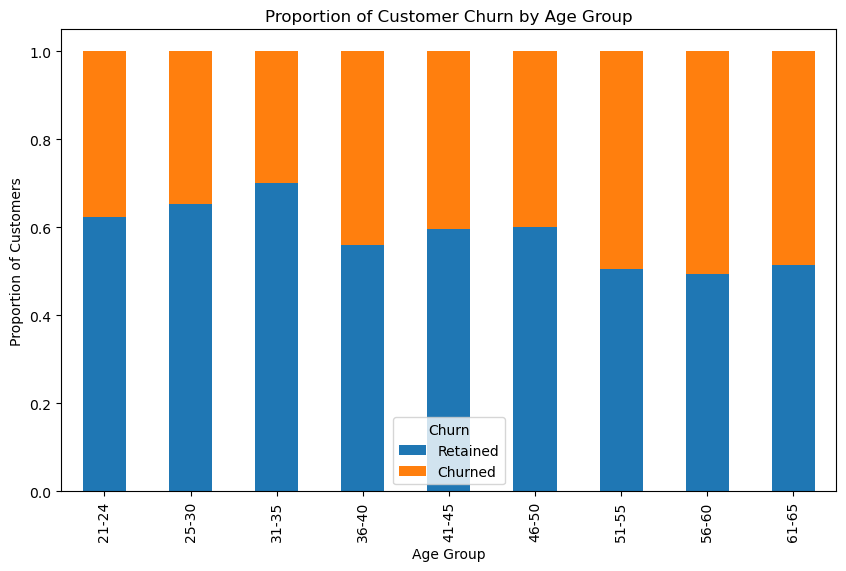

In [184]:
# Plotting
age_churn_proportion.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Proportion of Customer Churn by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Proportion of Customers')
plt.legend(title='Churn', labels=['Retained', 'Churned'])  
plt.show()

Given a binwidth of 5 years, we notice that there are non-linear patterns displayed between the age group and proportion of customers. As such, we will try to implement binning the ages in feature engineering

### **Data Normalization**

Normalization changes the values of the features in the dataset to a common scale, without distorting differences in the ranges of values or losing information. MinMaxScaler in particular, scales all these features to fit in a [0,1] interval.

In [195]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# List of columns to be normalized
columns_to_normalize = ['Age', 'AI_Interaction_Level', 'Satisfaction_with_AI_Services',
                        'AI_Personalization_Effectiveness', 'AI_Response_Time',
                        'Overall_Usage_Frequency', 'Customer_Service_Interactions',
                        'Change_in_Usage_Patterns', 'AI_Level_Squared', 'Age_Squared'] 

# Apply the scaler to your data
train_encoded_fe_bin[columns_to_normalize] = scaler.fit_transform(train_encoded_fe_bin[columns_to_normalize])
test_encoded_fe_bin[columns_to_normalize] = scaler.transform(test_encoded_fe_bin[columns_to_normalize])

In [196]:
train_encoded_fe_bin.shape

(5000, 23)

In [197]:
test_encoded_fe_bin.shape

(1250, 23)

## **Train and Test Set**

In [198]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from mlxtend.feature_selection import SequentialFeatureSelector
#from imblearn.over_sampling import SMOTE

In [199]:
#smote = SMOTE(random_state=42)

In [215]:
# y must be an integer in this case for RF to work
X_train_rnn = train_encoded_fe_bin.drop(columns=['ID', 'Customer_Churn', 'Age_Group'])  
y_train_rnn = train_encoded_fe_bin['Customer_Churn'].astype(int) 

X_test_rnn = test_encoded_fe_bin.drop(columns=['ID', 'Customer_Churn', 'Age_Group'])  # Features
y_test_rnn = test_encoded_fe_bin ['Customer_Churn']

#X_train_rnn, y_train_rnn = smote.fit_resample(X_train_rnn, y_train_rnn)

In [216]:
X_train_rnn.shape

(5000, 20)

In [217]:
X_test_rnn.shape

(1250, 20)

In [218]:
print(X_train_rnn.dtypes)

Age                                 float64
AI_Interaction_Level                float64
Satisfaction_with_AI_Services       float64
AI_Personalization_Effectiveness    float64
AI_Response_Time                    float64
Overall_Usage_Frequency             float64
Customer_Service_Interactions       float64
Change_in_Usage_Patterns            float64
Age_AI_Interaction                    int64
Overall_Satisfaction                float64
Age_Squared                         float64
AI_Level_Squared                    float64
Age_Group_25-30                     float64
Age_Group_31-35                     float64
Age_Group_36-40                     float64
Age_Group_41-45                     float64
Age_Group_46-50                     float64
Age_Group_51-55                     float64
Age_Group_56-60                     float64
Age_Group_61-65                     float64
dtype: object


In [219]:
print(X_test_rnn.dtypes)
X_test_rnn = test_encoded_fe_bin.drop(columns=['Age_Group'])  # Features
y_test_rnn = test_encoded_fe_bin ['Customer_Churn']

Age                                 float64
AI_Interaction_Level                float64
Satisfaction_with_AI_Services       float64
AI_Personalization_Effectiveness    float64
AI_Response_Time                    float64
Overall_Usage_Frequency             float64
Customer_Service_Interactions       float64
Change_in_Usage_Patterns            float64
Age_AI_Interaction                    int64
Overall_Satisfaction                float64
Age_Squared                         float64
AI_Level_Squared                    float64
Age_Group_25-30                     float64
Age_Group_31-35                     float64
Age_Group_36-40                     float64
Age_Group_41-45                     float64
Age_Group_46-50                     float64
Age_Group_51-55                     float64
Age_Group_56-60                     float64
Age_Group_61-65                     float64
dtype: object


## Data Preprocessing

## Training the 

In [220]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from keras_tuner import RandomSearch
from tensorflow.keras.optimizers import Adam

In [221]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=512, step=32),
                    activation='relu',
                    input_shape=(X_train_rnn.shape[1],)))
    model.add(Dropout(hp.Float('dropout_input', min_value=0, max_value=0.5, step=0.1)))
    
    for i in range(hp.Int('n_layers', 1, 3)):  # Number of hidden layers
        model.add(Dense(units=hp.Int(f'units_layer{i}', min_value=32, max_value=512, step=32),
                        activation='relu'))
        model.add(Dropout(hp.Float(f'dropout_layer{i}', min_value=0, max_value=0.5, step=0.1)))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [222]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='my_dir',
    project_name='keras_tuning'
)

tuner.search(X_train_rnn, y_train_rnn, epochs=10, validation_split=0.2, verbose=2)

Reloading Tuner from my_dir/keras_tuning/tuner0.json


In [223]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

# Summary of the best model
best_model.summary()

# Details of the best hyperparameters
print(f"""
The hyperparameter search is complete. The optimal number of units in the first hidden layer is {best_hps.get('units_input')}
and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 160)            │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,545 (33.38 KB)

 Trainable params: 8,545 (33.38 KB)

 Non-trainable params: 0 (0.00 B)


The hyperparameter search is complete. The optimal number of units in the first hidden layer is 160
and the optimal learning rate for the optimizer is 0.0001.



In [226]:
history = best_model.fit(X_train_rnn, y_train_rnn, epochs=50, validation_split=0.2, verbose=2)

Epoch 1/50
125/125 - 0s - 2ms/step - accuracy: 0.5813 - loss: 0.6608 - val_accuracy: 0.5870 - val_loss: 0.6536
Epoch 2/50
125/125 - 0s - 1ms/step - accuracy: 0.5840 - loss: 0.6618 - val_accuracy: 0.5970 - val_loss: 0.6488
Epoch 3/50
125/125 - 0s - 2ms/step - accuracy: 0.5928 - loss: 0.6575 - val_accuracy: 0.5920 - val_loss: 0.6522
Epoch 4/50
125/125 - 0s - 2ms/step - accuracy: 0.5978 - loss: 0.6597 - val_accuracy: 0.5990 - val_loss: 0.6502
Epoch 5/50
125/125 - 0s - 2ms/step - accuracy: 0.5900 - loss: 0.6582 - val_accuracy: 0.6000 - val_loss: 0.6473
Epoch 6/50
125/125 - 0s - 2ms/step - accuracy: 0.5945 - loss: 0.6616 - val_accuracy: 0.5720 - val_loss: 0.6706
Epoch 7/50
125/125 - 0s - 2ms/step - accuracy: 0.5840 - loss: 0.6671 - val_accuracy: 0.5960 - val_loss: 0.6476
Epoch 8/50
125/125 - 0s - 1ms/step - accuracy: 0.5945 - loss: 0.6587 - val_accuracy: 0.5860 - val_loss: 0.6569
Epoch 9/50
125/125 - 0s - 1ms/step - accuracy: 0.5950 - loss: 0.6594 - val_accuracy: 0.5950 - val_loss: 0.6482
E

In [227]:
loss, accuracy = best_model.evaluate(X_test_rnn, y_test_rnn)
print(f'Test accuracy: {accuracy:.2f}')

2024-03-16 21:49:51.216637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Matrix size-incompatible: In[0]: [32,22], In[1]: [20,160]
	 [[{{node sequential_1/dense_1/MatMul}}]]


InvalidArgumentError: Graph execution error:

Detected at node sequential_1/dense_1/MatMul defined at (most recent call last):
  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/runpy.py", line 87, in _run_code

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code

  File "/var/folders/6k/_q478z_52mg7tnr4nntvqnrm0000gn/T/ipykernel_1029/1436800777.py", line 1, in <module>

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 435, in evaluate

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 165, in one_step_on_iterator

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 153, in one_step_on_data

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 81, in test_step

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/keras/src/layers/layer.py", line 816, in __call__

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/keras/src/ops/operation.py", line 42, in __call__

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 157, in error_handler

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/keras/src/models/sequential.py", line 203, in call

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/keras/src/models/functional.py", line 188, in call

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/keras/src/ops/function.py", line 153, in _run_through_graph

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/keras/src/models/functional.py", line 572, in call

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/keras/src/layers/layer.py", line 816, in __call__

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/keras/src/ops/operation.py", line 42, in __call__

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 157, in error_handler

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/keras/src/layers/core/dense.py", line 137, in call

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/keras/src/ops/numpy.py", line 3547, in matmul

  File "/Users/roselinakeziarijadi/opt/anaconda3/envs/newenv/lib/python3.9/site-packages/keras/src/backend/tensorflow/numpy.py", line 239, in matmul

Matrix size-incompatible: In[0]: [32,22], In[1]: [20,160]
	 [[{{node sequential_1/dense_1/MatMul}}]] [Op:__inference_one_step_on_iterator_182992]